In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import matplotlib.pyplot as plt
import seaborn as sns

import scipy

In [72]:
import pandas as pd
import numpy as np
from datetime import datetime, date

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
df = pd.read_csv('Cross Road Analytics Competition Dataset.csv')
df.head()

/var/folders/vg/7d4f1ys12s17fxmrbfx48h4h0000gn/T/ipykernel_5161/4197311411.py:1: DtypeWarning: Columns (0,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Cross Road Analytics Competition Dataset.csv')


,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,...,SeatUniqueID,Season,ClubExpYear,Tenure,UniqueID,isAttended,Resold,ResalePrice,ResaleDate,isSTM
0,117948790,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,1,FR,...,101-10-1,2021,NaN,25.0,CLT21HOU-101-10-1,Yes,NaN,NaN,NaN,NaN
1,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,10,FR,...,101-10-10,2021,NaN,20.0,CLT21HOU-101-10-10,No,NaN,NaN,NaN,NaN
2,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,11,FR,...,101-10-11,2021,NaN,20.0,CLT21HOU-101-10-11,No,NaN,NaN,NaN,NaN
3,1489599590,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,12,FR,...,101-10-12,2021,NaN,4.0,CLT21HOU-101-10-12,Yes,NaN,NaN,NaN,NaN
4,115101990,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,13,FR,...,101-10-13,2021,NaN,32.0,CLT21HOU-101-10-13,No,NaN,NaN,NaN,NaN


In [64]:
df.shape

(1158228, 34)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158228 entries, 0 to 1158227
Data columns (total 34 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   acct_id          1158228 non-null  object 
 1   acct_type_desc   1074743 non-null  object 
 2   event_name       1158228 non-null  object 
 3   event_date       1158228 non-null  object 
 4   plan_event_name  906065 non-null   object 
 5   comp_name        1084292 non-null  object 
 6   section_name     1158228 non-null  int64  
 7   row_name         1158228 non-null  object 
 8   SeatNum          1158228 non-null  int64  
 9   price_code       1158228 non-null  object 
 10  PC1              1158228 non-null  object 
 11  Price            1158228 non-null  float64
 12  paid             1018942 non-null  object 
 13  add_datetime     1084292 non-null  object 
 14  class_name       1158228 non-null  object 
 15  status           1158228 non-null  object 
 16  Sales_Source     5

## Visualizing Target Variable

Text(0, 0.5, '# of Observations')

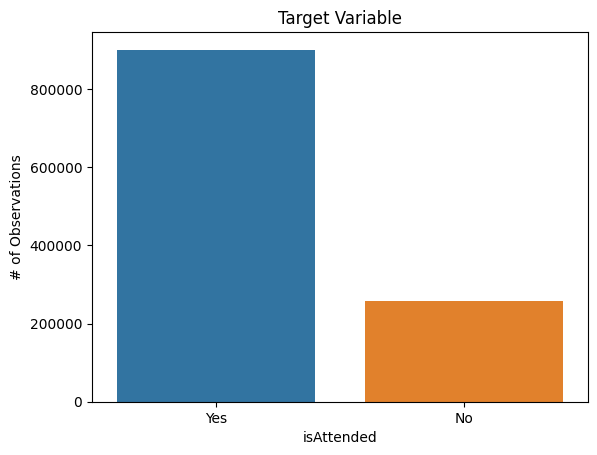

In [66]:
sns.countplot(x = df['isAttended'])
plt.title('Target Variable')
plt.ylabel('# of Observations')

### We can see there is a clear class imbalance in the dataset. We will handle this using classweights

### Feature Engineering:
- Adding new columns for date features
- Grouping categorical columns
- Log transform of numerical columns

In [10]:
def join_col(y):
    if y['acct_type_desc_mod'] == 'Club' and 'Club' in y['exp_combined']:
        return y['exp_combined']
    else:
        return y['acct_type_desc_mod']
    
df['exp_combined'] =  df['ClubExpYear'].apply(lambda x: 'Club ' + str(x) if x>0 else '')

df['acct_type_desc_mod'] = df['acct_type_desc'].apply(lambda x: 'Huntington' 
                                                      if 'Huntington' in str(x) else x)
df['acct_type_desc_mod'] = df['acct_type_desc_mod'].apply(lambda x: 'Group'
                                                          if 'Group' in str(x) else x)
df['acct_type_desc_mod'] = df['acct_type_desc_mod'].apply(lambda x: 'Hold'
                                                          if 'Hold' in str(x) else x)
    
    
df['acct_type_desc_grp'] = df.apply(lambda x: join_col(x), axis = 1)

In [13]:
df['TicketClass_mode'] = df['TicketClass'].apply(lambda x: 'Obstruct' 
                                                      if 'Obstruct' in str(x) else x)

In [14]:
df['TicketClass_mode'].value_counts()

Manifest    1071660
Infill        42426
SRO           18097
ADA           13662
Obstruct      12383
Name: TicketClass_mode, dtype: int64

In [15]:
df['row_name_new'] = df['row_name'].apply(lambda x: 'N' if 'N' in x else 
                                              ('W' if 'W' in x else('SR' if 'SR' in x else 'number')))

In [16]:
pd.set_option("display.max_rows", None)
df['price_code'].nunique()

1145

In [17]:
df.describe()

,section_name,SeatNum,Price,Sales_Source,isHost,Start Year,LastYear,Term,Season,ClubExpYear,Tenure,ResalePrice,isSTM
count,1.158228e+06,1.158228e+06,1.158228e+06,5578.000000,1.158228e+06,126519.000000,126519.000000,126411.000000,1158228.0,126519.000000,1.074743e+06,134496.000000,348509.0
mean,3.688552e+02,1.175930e+01,1.189659e+02,5884.231086,5.642240e-02,2019.641169,2022.589500,3.496705,2021.5,2022.589500,1.204297e+01,214.838301,1.0
std,2.001974e+02,7.263610e+00,8.632297e+01,4743.881331,2.307357e-01,2.075772,0.942288,0.978438,0.5,0.942288,1.190147e+01,278.638565,0.0
min,1.010000e+02,1.000000e+00,0.000000e+00,9.000000,0.000000e+00,2016.000000,2021.000000,1.000000,2021.0,2021.000000,0.000000e+00,0.000000,1.0
25%,1.480000e+02,6.000000e+00,6.000000e+01,9.000000,0.000000e+00,2019.000000,2022.000000,3.000000,2021.0,2022.000000,2.000000e+00,69.000000,1.0
50%,4.040000e+02,1.100000e+01,1.010000e+02,9454.000000,0.000000e+00,2021.000000,2023.000000,3.000000,2021.5,2023.000000,9.000000e+00,135.000000,1.0
75%,6.090000e+02,1.700000e+01,1.450000e+02,10191.000000,0.000000e+00,2021.000000,2023.000000,5.000000,2022.0,2023.000000,1.800000e+01,250.000000,1.0
max,6.460000e+02,5.000000e+01,7.800000e+02,10605.000000,1.000000e+00,2022.000000,2024.000000,5.000000,2022.0,2024.000000,3.800000e+01,5792.000000,1.0


In [18]:
pd.set_option("display.max_rows", 10)

In [19]:
df['plan_event_name'].value_counts()

22FS        453968
21FS        430392
22FS8        19061
21FS9         1756
22MPACK        850
22FS9           32
22MPACK2         6
Name: plan_event_name, dtype: int64

In [20]:
df['price_code_mod'] = df['price_code'].str[1:]
df['price_code_mod'].value_counts()

R      602693
        98386
N       95693
RM      51145
S03     25290
        ...  
MM2         4
GW5         4
SIB         4
SI8         2
01W         2
Name: price_code_mod, Length: 205, dtype: int64

In [23]:
df[df['acct_type_desc'] == 'Club'][['acct_type_desc', 'ClubExpYear']].isnull().sum()

acct_type_desc        0
ClubExpYear       16452
dtype: int64

In [25]:
df['acct_type_desc_mod'] = df['acct_type_desc'].apply(lambda x: 'Huntington' 
                                                      if 'Huntington' in str(x) else x)
df['acct_type_desc_mod'] = df['acct_type_desc_mod'].apply(lambda x: 'Group'
                                                          if 'Group' in str(x) else x)
df['acct_type_desc_mod'] = df['acct_type_desc_mod'].apply(lambda x: 'Hold'
                                                          if 'Hold' in str(x) else x)


In [27]:
df['exp_combined'] =  df['ClubExpYear'].apply(lambda x: 'Club ' + str(x) if x>0 else 'b')
df['exp_combined'].value_counts()

b              1031709
Club 2023.0      47238
Club 2022.0      38421
Club 2024.0      22735
Club 2021.0      18125
Name: exp_combined, dtype: int64

In [28]:
df['acct_type_desc_mod'] = df['acct_type_desc_mod'].apply(lambda x: ()
                                                          if 'Group' in str(x) else x)


In [29]:
df['acct_type_desc_mod'].value_counts()

Season            628879
Club              134181
House             112408
Personal           71958
Sponsor            45106
()                 28389
Employee           26865
Comp                9310
Suite               6076
Player              4401
Opponents           3063
Single Game         2346
Huntington          1545
SG Suite             135
IU 2022               31
Kids Club             15
NONRENEWAL            15
Hold                  10
Window Account         8
Premium                2
Name: acct_type_desc_mod, dtype: int64

In [30]:
df['acct_type_desc_mod'] = df['acct_type_desc_mod'].apply(lambda x: ()
                                                          if 'Group' in str(x) else x)


In [31]:
df[df['acct_type_desc'] == 'Club'][['acct_type_desc', 'ClubExpYear', 'isAttended']].value_counts()

acct_type_desc  ClubExpYear  isAttended
Club            2023.0       Yes           38298
                2022.0       Yes           28687
                2024.0       Yes           18351
                2021.0       Yes           11731
                2023.0       No             7876
                2022.0       No             6513
                2024.0       No             3600
                2021.0       No             2673
dtype: int64

In [ ]:
df['price_code_mod'].fillna('other')

In [36]:
df['plan_event_name'].value_counts()

22FS        453968
21FS        430392
22FS8        19061
21FS9         1756
22MPACK        850
22FS9           32
22MPACK2         6
Name: plan_event_name, dtype: int64

In [37]:
sum(df['ClubExpYear'] == (df['Term'] + 2020))

47607

In [41]:
temp = df[['acct_id', 'event_date']].groupby(['acct_id', 'event_date']).count().reset_index()

In [42]:
df.shape

(1158228, 40)

In [43]:
df['lagged'] = df.groupby(['acct_id'])['event_date'].shift(1)

In [44]:
df['acct_id'] = df['acct_id'].astype(str)
df.sort_values(by = ['acct_id', 'event_date'])

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,...,ResalePrice,ResaleDate,isSTM,exp_combined,acct_type_desc_mod,acct_type_desc_grp,TicketClass_mode,row_name_new,price_code_mod,lagged
159149,01-190,Personal,CLT21LAR,2021-09-19,NaN,Not Comp,347,3N,1,I,...,NaN,NaN,NaN,b,Personal,Personal,Infill,N,,NaN
159160,01-190,Personal,CLT21LAR,2021-09-19,NaN,Not Comp,347,3N,2,I,...,NaN,NaN,NaN,b,Personal,Personal,Infill,N,,2021-09-19
545225,01-190,Personal,CLT21TEN,2021-10-31,NaN,Not Comp,347,3N,1,I,...,NaN,NaN,NaN,b,Personal,Personal,Infill,N,,2021-09-19
545236,01-190,Personal,CLT21TEN,2021-10-31,NaN,Not Comp,347,3N,2,I,...,NaN,NaN,NaN,b,Personal,Personal,Infill,N,,2021-10-31
287216,01-290,Personal,CLT21NYJ,2021-11-04,NaN,Not Comp,338,4N,6,9,...,NaN,NaN,NaN,b,Personal,Personal,Infill,N,,2021-11-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405295,199890690,Single Game,CLT21SEA,2021-09-12,NaN,Media,209,12,6,CS,...,NaN,NaN,NaN,b,Single Game,Single Game,Manifest,number,S,2021-09-12
405319,199890690,Single Game,CLT21SEA,2021-09-12,NaN,Media,209,13,3,CS,...,NaN,NaN,NaN,b,Single Game,Single Game,Manifest,number,S,2021-09-12
405320,199890690,Single Game,CLT21SEA,2021-09-12,NaN,Media,209,13,4,CS,...,NaN,NaN,NaN,b,Single Game,Single Game,Manifest,number,S,2021-09-12
405321,199890690,Single Game,CLT21SEA,2021-09-12,NaN,Media,209,13,5,CS,...,NaN,NaN,NaN,b,Single Game,Single Game,Manifest,number,S,2021-09-12


In [45]:
df['lagged'] = df['lagged'].fillna(0)

In [46]:
df['between_event_date'] = (pd.to_datetime(df['event_date']) - pd.to_datetime(df['lagged'])).dt.days

### Creating new date features

In [50]:
df['event_date'] =  pd.to_datetime(df['event_date'], errors = 'coerce')

In [51]:
df['add_datetime'] =  pd.to_datetime(df['add_datetime'], errors = 'coerce')

In [52]:
df['ResaleDate'] =  pd.to_datetime(df['ResaleDate'], errors = 'coerce')

In [53]:
df['event_date_month'] = pd.DatetimeIndex(df['event_date']).month

In [54]:
df['event_date_weekday'] = pd.DatetimeIndex(df['event_date']).dayofweek

In [55]:
cal = calendar()
holidays = cal.holidays(start=df['event_date'].min(), end=df['event_date'].max())
df['event_holiday_or_not'] = df['event_date'].isin(holidays)

In [56]:
df['event_holiday_or_not'].value_counts()

False    1093882
True       64346
Name: event_holiday_or_not, dtype: int64

<AxesSubplot:xlabel='isAttended', ylabel='count'>

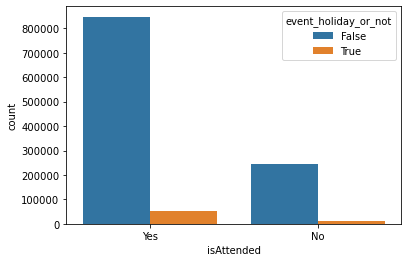

In [57]:
sns.countplot(x = df['isAttended'], hue = df['event_holiday_or_not'])

### Grouping section based in price

In [59]:
df.loc[df['section_name'].isin([148,151,152,153,101,102,103,105,121,124,125,126,127,128,129,132]), 'Section_Name_based_on_price'] = 'Yellow'
df.loc[df['section_name'].isin([141,140,139,240,112,113,114,213]), 'Section_Name_based_on_price'] = 'Blue_striped'
df.loc[df['section_name'].isin([204,205,206,307,308,318,319,220,221,222,223,224,225,227,228,229,230,231,232,233,247,248,249,334,335,345,346]), 'Section_Name_based_on_price'] = 'Red'
df.loc[df['section_name'].isin([111,115,212,214,313,142,138,241,239,340]), 'Section_Name_based_on_price'] = 'Purple_stripped'
df.loc[df['section_name'].isin([242,238,341,339,440,211,215,312,314,413]), 'Section_Name_based_on_price'] = 'Orange_stripped'
df.loc[df['section_name'].isin([342,338,441,439,311,315,412,414,442,438,411,415]), 'Section_Name_based_on_price'] = 'Green_stripped'
df.loc[df['section_name'].isin([143,137,110,116]), 'Section_Name_based_on_price'] = 'Pink'
df.loc[df['section_name'].isin([144,136,243,237,109,117,210,216]), 'Section_Name_based_on_price'] = 'Lambert'
df.loc[df['section_name'].isin([145,135,245,235,344,443,336,437,108,118,208,218,309,410,317,416]), 'Section_Name_based_on_price'] = 'Dark_blue'
df.loc[df['section_name'].isin([244,236,343,337,209,217,310,316]), 'Section_Name_based_on_price'] = 'Purple_dark'
df.loc[df['section_name'].isin([349,347,446,543,542,538,537,434,333,331,330,329,328,327,326,325,324,323,322,320,419,516,515,511,510,407,306,304]), 'Section_Name_based_on_price'] = 'Light_Green'
df.loc[df['section_name'].isin([445,541,540,539,435,418,514,513,512,408]), 'Section_Name_based_on_price'] = 'Yellowish_green'
df.loc[df['section_name'].isin([444,436,409,417]), 'Section_Name_based_on_price'] = 'Grey_dark'
df.loc[df['section_name'].isin([545,544,536,535,430,429,428,427,425,424,423,518,517,509,508]), 'Section_Name_based_on_price'] = 'Dark_brown'
df.loc[df['section_name'].isin([449,447,433,431,422,420,404,406]), 'Section_Name_based_on_price'] = 'Brown_light'
df.loc[df['section_name'].isin([549,547,533,531,522,520,504,506,524,525,526,527,528,529]), 'Section_Name_based_on_price'] = 'Grey_light'
df.loc[df['section_name'].isin([450,451,452,453,401,402,403]), 'Section_Name_based_on_price'] = 'Blue'
df.loc[df['section_name'].isin([633,632,631,605,604,606]), 'Section_Name_based_on_price'] = 'Green_Dark'
df.loc[df['section_name'].isin([624,625,626,627,628,629,644,643,642,638,637,636,609,610,611,615,616,617]), 'Section_Name_based_on_price'] = 'White'
df.loc[df['section_name'].isin([612,613,614,641,640,639]), 'Section_Name_based_on_price'] = 'Violet'
df.loc[df['section_name'].isin([646,645,635,634,618,619,607,608]), 'Section_Name_based_on_price'] = 'Violetish_red'
df.loc[df['section_name'].isin([546,534,507,519]), 'Section_Name_based_on_price'] = 'Green_blackish'
df.loc[df['section_name'].isin([303,350]), 'Section_Name_based_on_price'] = 'Orange'

In [61]:
c = df.groupby(['TicketType','isAttended'])['isAttended'].count()
d = c / c.groupby(level=0).sum()
d

TicketType      isAttended
ADA Avail       No            0.992798
                Yes           0.007202
Broker          No            0.144700
                Yes           0.855300
Comp            No            0.415624
                                ...   
SingleGm Avail  Yes           0.000416
Sponsor         No            0.280280
                Yes           0.719720
Upgrade         No            0.127609
                Yes           0.872391
Name: isAttended, Length: 47, dtype: float64

In [62]:
df['TicketType'].value_counts()

Renewal          542603
New              119693
Broker           107920
Existing          89767
SingleGame        68065
                  ...  
FlexPack            733
Other SOLD          197
Other               101
Premium Avail         6
Held                  5
Name: TicketType, Length: 26, dtype: int64

In [63]:
df['TicketClass'].value_counts()

Manifest           1071660
Infill               42426
SRO                  18097
ADA                  13662
Obstructed View       6257
Obstruct              6126
Name: TicketClass, dtype: int64

In [66]:
df['plan_event_name'] = df['plan_event_name'].str[2:]

In [67]:
df['plan_event_name'].value_counts()

FS        884360
FS8        19061
FS9         1788
MPACK        850
MPACK2         6
Name: plan_event_name, dtype: int64

In [68]:
df['comp_name'].value_counts()

Not Comp                        1037158
Front Office/Club Staff           10624
Promotions                         7081
Charity/Community Relations        5662
Youth Football                     3676
                                 ...   
Game Official and Chain Crew        333
Customer Service                     93
Club Alumni                          79
Ownership Guests                     59
League Employees                     47
Name: comp_name, Length: 22, dtype: int64

In [69]:
l = ['Charity/Community Relations', 'Military', 'Miscellaneous', 'Youth Football', 'archiveBusiness']

In [70]:
df["comp_name_group"] = df['comp_name'].apply(lambda x: 0 if (x == 'Not Comp') 
                                                                   else (1 if x in l else 2))

In [71]:
df["comp_name_group"].value_counts()

0    1037158
2     106082
1      14988
Name: comp_name_group, dtype: int64

In [72]:
c = df.groupby(['comp_name','isAttended'])['isAttended'].count()
d = c / c.groupby(level=0).sum()
d

comp_name                    isAttended
Charity/Community Relations  No            0.666372
                             Yes           0.333628
Club Alumni                  No            0.164557
                             Yes           0.835443
Coaches & Trainers           No            0.297798
                                             ...   
VIP/Local Dignitaries        Yes           0.868304
Youth Football               No            0.535365
                             Yes           0.464635
archiveBusiness              No            0.590753
                             Yes           0.409247
Name: isAttended, Length: 44, dtype: float64

In [73]:
df['price_code'].value_counts()

FR      115327
GR       68356
DR       52111
BR       50570
JR       34199
         ...  
9SI9         1
6S09         1
RGZ3         1
SSI7         1
6S07         1
Name: price_code, Length: 1145, dtype: int64

In [74]:
df['paid'].value_counts()

Y    968359
N     50229
P       354
Name: paid, dtype: int64

In [76]:
df['event_date_day'] = pd.DatetimeIndex(df['event_date']).day

In [77]:
df["isEndMonth"] = df['event_date_day'].apply(lambda x: 1 if (x >= 5) 
                                                                  and (x < 28) else 0)

<AxesSubplot:xlabel='isAttended', ylabel='count'>

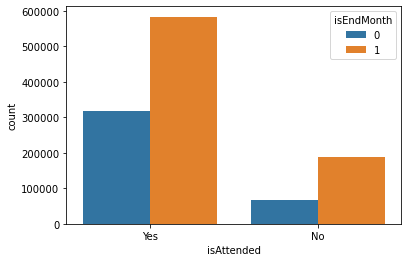

In [78]:
sns.countplot(x = df['isAttended'], hue = df['isEndMonth'])

In [79]:
df["isAttended"] = df['isAttended'].apply(lambda x: 1 if (x == 'Yes') else 0)

In [82]:
df['acct_type_desc'].fillna("Unknown",inplace = True)
df.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,...,price_code_mod,lagged,between_event_date,event_date_month,event_date_weekday,event_holiday_or_not,Section_Name_based_on_price,comp_name_group,event_date_day,isEndMonth
0,117948790,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,1,FR,...,R,0,18917,10,6,False,Yellow,0,17,1
1,126665090,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,10,FR,...,R,0,18917,10,6,False,Yellow,0,17,1
2,126665090,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,11,FR,...,R,2021-10-17,0,10,6,False,Yellow,0,17,1
3,1489599590,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,12,FR,...,R,0,18917,10,6,False,Yellow,0,17,1
4,115101990,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,13,FR,...,R,0,18917,10,6,False,Yellow,0,17,1


In [83]:
x = df[df['plan_event_name'].isnull()]
x

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,...,price_code_mod,lagged,between_event_date,event_date_month,event_date_weekday,event_holiday_or_not,Section_Name_based_on_price,comp_name_group,event_date_day,isEndMonth
114,190,Unknown,CLT21HOU,2021-10-17,NaN,NaN,101,15,13,FS03,...,S03,0,18917,10,6,False,Yellow,2,17,1
115,190,Unknown,CLT21HOU,2021-10-17,NaN,NaN,101,15,14,FS03,...,S03,2021-10-17,0,10,6,False,Yellow,2,17,1
710,190,Unknown,CLT21HOU,2021-10-17,NaN,NaN,101,SR1,1,Y,...,,2021-10-17,0,10,6,False,Yellow,2,17,1
711,190,Unknown,CLT21HOU,2021-10-17,NaN,NaN,101,SR1,10,Y,...,,2021-10-17,0,10,6,False,Yellow,2,17,1
712,190,Unknown,CLT21HOU,2021-10-17,NaN,NaN,101,SR1,11,Y,...,,2021-10-17,0,10,6,False,Yellow,2,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158140,1893832290,Personal,CLT22WAS,2022-10-30,NaN,Not Comp,646,21,5,SMF,...,MF,2022-10-30,0,10,6,False,Violetish_red,0,30,0
1158141,1893832290,Personal,CLT22WAS,2022-10-30,NaN,Not Comp,646,21,6,SMF,...,MF,2022-10-30,0,10,6,False,Violetish_red,0,30,0
1158142,1893832290,Personal,CLT22WAS,2022-10-30,NaN,Not Comp,646,21,7,SMF,...,MF,2022-10-30,0,10,6,False,Violetish_red,0,30,0
1158143,1893832290,Personal,CLT22WAS,2022-10-30,NaN,Not Comp,646,21,8,SMF,...,MF,2022-10-30,0,10,6,False,Violetish_red,0,30,0


In [84]:
mode_df=df.groupby(['event_date'])['plan_event_name'].agg(pd.Series.mode).reset_index()

In [85]:
merged_df=pd.merge(df,mode_df,on=['event_date'],how='inner')
merged_df

,acct_id,acct_type_desc,event_name,event_date,plan_event_name_x,comp_name,section_name,row_name,SeatNum,price_code,...,lagged,between_event_date,event_date_month,event_date_weekday,event_holiday_or_not,Section_Name_based_on_price,comp_name_group,event_date_day,isEndMonth,plan_event_name_y
0,117948790,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,1,FR,...,0,18917,10,6,False,Yellow,0,17,1,FS
1,126665090,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,10,FR,...,0,18917,10,6,False,Yellow,0,17,1,FS
2,126665090,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,11,FR,...,2021-10-17,0,10,6,False,Yellow,0,17,1,FS
3,1489599590,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,12,FR,...,0,18917,10,6,False,Yellow,0,17,1,FS
4,115101990,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,13,FR,...,0,18917,10,6,False,Yellow,0,17,1,FS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158223,1831131890,Season,CLT22WAS,2022-10-30,FS,Not Comp,646,9,5,RN,...,2022-10-30,0,10,6,False,Violetish_red,0,30,0,FS
1158224,1831131890,Season,CLT22WAS,2022-10-30,FS,Not Comp,646,9,6,RN,...,2022-10-30,0,10,6,False,Violetish_red,0,30,0,FS
1158225,1246180690,Sponsor,CLT22WAS,2022-10-30,FS8,Not Comp,646,9,7,RR,...,2022-10-30,0,10,6,False,Violetish_red,0,30,0,FS
1158226,1246180690,Sponsor,CLT22WAS,2022-10-30,FS8,Not Comp,646,9,8,RR,...,2022-10-30,0,10,6,False,Violetish_red,0,30,0,FS


In [86]:
merged_df['plan_event_name_x'].fillna(merged_df['plan_event_name_y'],inplace=True)
merged_df.shape

(1158228, 50)

In [87]:
merged_df.drop(columns=['plan_event_name_y'],inplace=True)
merged_df.rename(columns={'plan_event_name_x':'plan_event_name'},inplace=True)
df=merged_df.copy()
df.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,...,price_code_mod,lagged,between_event_date,event_date_month,event_date_weekday,event_holiday_or_not,Section_Name_based_on_price,comp_name_group,event_date_day,isEndMonth
0,117948790,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,1,FR,...,R,0,18917,10,6,False,Yellow,0,17,1
1,126665090,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,10,FR,...,R,0,18917,10,6,False,Yellow,0,17,1
2,126665090,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,11,FR,...,R,2021-10-17,0,10,6,False,Yellow,0,17,1
3,1489599590,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,12,FR,...,R,0,18917,10,6,False,Yellow,0,17,1
4,115101990,Season,CLT21HOU,2021-10-17,FS,Not Comp,101,10,13,FR,...,R,0,18917,10,6,False,Yellow,0,17,1


### Saving the dataset

In [150]:
df.to_csv("train_data_nolog_pc.csv",index=False)